# Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv1DTranspose, MaxPool1D, Dropout, Reshape, Lambda, InputLayer, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import BinaryCrossentropy


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## Test GPU

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data preparation

In [12]:
data = np.loadtxt(r'C:\Users\lucas\Documents\GitHub\INT\Manufatura Aditiva\Simulacao-GAN\Pipeline\4- Machine_learning\Data_extraction\data\data_isotropy.csv',delimiter=',')
X = data[:,:-1]
y = data[:,-1]
y = y.reshape((y.shape[0],1))

# scaler = MinMaxScaler()
# y = scaler.fit_transform(y).round(10)
# sns.histplot(y)

test = 0.3
num_test = int(len(X)*test)
num_train = len(X)-num_test
train_indexes = np.random.choice(data.shape[0], num_train, replace=False)  

X_train = X[train_indexes]
y_train = y[train_indexes]

input_G = 100
output_G = input_D = len(X[0])
output_D = 1

X_test = np.delete(X,train_indexes, 0)
y_test = np.delete(y,train_indexes, 0)

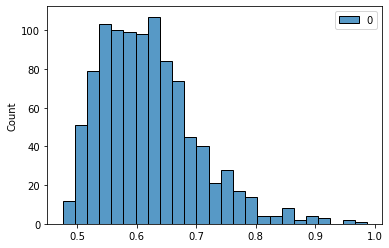

In [13]:
sns.histplot(y)

# Models definition

## Generator

In [14]:
G = Sequential(name='Generator')
G.add(InputLayer(input_shape=(input_G,)))
G.add(Dense(input_G, activation = 'relu'))
# G.add(Dropout(0.5))
G.add(Dense(int(input_G*1.5625), activation = 'relu'))
# # G.add(Dropout(0.5))
G.add(Reshape((int(input_G*1.5625), 1)))
G.add(Conv1D(64, 3, activation='relu'))
G.add(Conv1D(32, 3, activation='relu'))
G.add(Conv1DTranspose(1, 3, padding='same',activation='tanh'))
G.add(Flatten())
G.add(Dense(output_G, activation = 'sigmoid'))

print(G.summary())

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 156)               15756     
_________________________________________________________________
reshape (Reshape)            (None, 156, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 154, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 152, 32)           6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 152, 1)            97        
_________________________________________________________________
flatten (Flatten)            (None, 152)               0 

## Discriminator

In [15]:
# D = Sequential()
# D.add(InputLayer(input_shape=(input_D,)))
# D.add(Reshape((input_D, 1)))
# D.add(Conv1D(32, 3, activation=LeakyReLU()))
# D.add(BatchNormalization())
# D.add(Conv1D(64, 3, activation=LeakyReLU()))
# D.add(BatchNormalization())
# D.add(Flatten())
# D.add(Dense(16, activation = 'relu'))
# D.add(Dense(1,activation='sigmoid'))

D = Sequential(name='Discriminator')
D.add(InputLayer(input_shape=(input_D,)))
D.add(Reshape((input_D, 1)))
D.add(Conv1D(64, 3, padding='same', input_shape=(input_D,), activation=LeakyReLU(alpha=0.2)))
D.add(BatchNormalization())
D.add(Dropout(0.4))
D.add(Conv1D(32, 3, padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(BatchNormalization())
D.add(Dropout(0.4))
D.add(Flatten())
D.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mse'])

D.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 196, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 64)           256       
_________________________________________________________________
batch_normalization (BatchNo (None, 196, 64)           256       
_________________________________________________________________
dropout (Dropout)            (None, 196, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 196, 32)           6176      
_________________________________________________________________
batch_normalization_1 (Batch (None, 196, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 32)         

## Setup GAN

In [16]:
def bce_with_style(y_true,y_pred,alpha=0.03):
#     ϕ = np.where(gen_X==0)[0].shape[0]/((int(np.sqrt(X.shape[0]))+1)**2)
    return bce(y_true, y_pred)+alpha*(ϕ-0.5)

def setup_GAN(G_model,D_model):
#     optimizer = RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=6e-8)
    optimizer = Adam(learning_rate=0.0001)
    D_model.trainable = False
    GAN = Sequential()
    GAN.add(G_model)
    GAN.add(D_model)
    GAN.compile(loss='binary_crossentropy', \
               optimizer=optimizer, \
               metrics=['mse'])
    return GAN

# Training

## Only D

In [17]:
batch_size = 32
num_epochs = 100

hist = D.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, verbose=1, validation_split = 0.4)

Epoch 1/100
14/14 [==============================] - 3s 55ms/step - loss: 0.9771 - mse: 0.1077 - val_loss: 0.6931 - val_mse: 0.0230
Epoch 2/100
14/14 [==============================] - 0s 11ms/step - loss: 0.9456 - mse: 0.0947 - val_loss: 0.6864 - val_mse: 0.0196
Epoch 3/100
14/14 [==============================] - 0s 11ms/step - loss: 0.9373 - mse: 0.0855 - val_loss: 0.6824 - val_mse: 0.0176
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 0.9241 - mse: 0.0858 - val_loss: 0.6797 - val_mse: 0.0163
Epoch 5/100
14/14 [==============================] - 0s 11ms/step - loss: 0.9280 - mse: 0.0845 - val_loss: 0.6767 - val_mse: 0.0148
Epoch 6/100
14/14 [==============================] - 0s 11ms/step - loss: 0.9133 - mse: 0.0802 - val_loss: 0.6750 - val_mse: 0.0139
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 0.9267 - mse: 0.0867 - val_loss: 0.6729 - val_mse: 0.0129
Epoch 8/100
14/14 [==============================] - 0s 10ms/step - loss: 0.

14/14 [==============================] - 0s 11ms/step - loss: 0.7908 - mse: 0.0498 - val_loss: 0.6805 - val_mse: 0.0149
Epoch 63/100
14/14 [==============================] - 0s 10ms/step - loss: 0.7835 - mse: 0.0483 - val_loss: 0.6822 - val_mse: 0.0157
Epoch 64/100
14/14 [==============================] - 0s 11ms/step - loss: 0.7942 - mse: 0.0521 - val_loss: 0.6809 - val_mse: 0.0154
Epoch 65/100
14/14 [==============================] - 0s 11ms/step - loss: 0.7748 - mse: 0.0449 - val_loss: 0.6753 - val_mse: 0.0131
Epoch 66/100
14/14 [==============================] - 0s 12ms/step - loss: 0.7866 - mse: 0.0483 - val_loss: 0.6775 - val_mse: 0.0139
Epoch 67/100
14/14 [==============================] - 0s 11ms/step - loss: 0.7732 - mse: 0.0461 - val_loss: 0.6760 - val_mse: 0.0133
Epoch 68/100
14/14 [==============================] - 0s 11ms/step - loss: 0.7856 - mse: 0.0481 - val_loss: 0.6768 - val_mse: 0.0135
Epoch 69/100
14/14 [==============================] - 0s 11ms/step - loss: 0.7661 

### Metrics

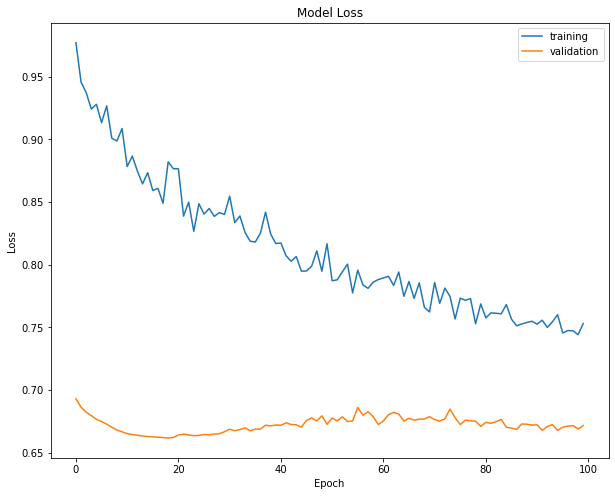

0.01167868038739555

In [18]:
fig = plt.figure(frameon=False,figsize=(10,8))
plt.plot(hist.history['loss'], label='training')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.show()

y_pred = D.predict(X_test)
y_test = y_test.reshape((y_test.shape[0],1))
mean_squared_error(y_pred,y_test)

## GAN

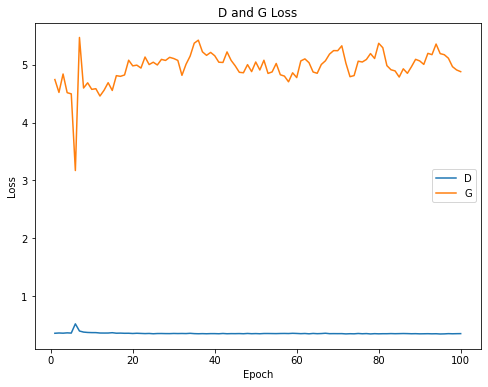

In [33]:
batch_size = 32
num_epochs = 100

batch_per_epoch = int(X_train.shape[0] /batch_size)
half_batch = int(batch_size/2)

GAN = setup_GAN(G,D)

G_losses = []
D_losses = []


for i in range(num_epochs):
    G_losses_epoch = []
    D_losses_epoch = []
    
    for j in range(batch_per_epoch):
        real_indexes = np.random.choice(X.shape[0], half_batch, replace=False)
        X_real = X[real_indexes]
        y_real= y[real_indexes]
        
        noise = np.random.randn(half_batch, input_G)
        X_fake = G.predict(noise)
        y_fake = np.zeros((half_batch, 1))
        
        X_D = np.concatenate((X_fake,X_real),axis=0)
        y_D = np.concatenate((y_fake,y_real),axis=0)
        
        D_loss,_ = D.train_on_batch(X_D, y_D)
        D_losses_epoch.append(D_loss)
        
        X_GAN = np.random.randn(batch_size, input_G)
        y_GAN = np.ones((batch_size, 1))
        G_loss,_ = GAN.train_on_batch(X_GAN, y_GAN)
        G_losses_epoch.append(G_loss)
#         print('>%d, %d/%d, D_loss=%.3f, G_loss=%.3f' % (i+1, j+1, batch_per_epoch, D_loss, G_loss))
    
    G_losses.append(G_losses_epoch)
    D_losses.append(D_losses_epoch)
        

G_losses = np.array(G_losses)
D_losses = np.array(D_losses)

fig = plt.figure(frameon=False,figsize=(8,6))
plt.plot(range(1,num_epochs+1),np.mean(D_losses,axis=1), label='D')
plt.title('D and G Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(range(1,num_epochs+1),np.mean(G_losses,axis=1), label='G')
plt.legend()
plt.show()

In [36]:
noise = np.random.randn(1000, input_G)
GAN.predict(noise)

# scaler = MinMaxScaler()
# test = scaler.fit_transform(gen[3].reshape(len(gen[0]),1)).round().reshape((int(np.sqrt(X[0].shape[0])),int(np.sqrt(X[0].shape[0]))))
# plt.imshow(test)

array([[0.00605117],
       [0.00605571],
       [0.00607557],
       [0.00605562],
       [0.00606143],
       [0.00605259],
       [0.00605623],
       [0.00605168],
       [0.00606928],
       [0.00605757],
       [0.00606086],
       [0.00605633],
       [0.0060571 ],
       [0.00605879],
       [0.00608109],
       [0.00604766],
       [0.00605472],
       [0.00606207],
       [0.00605459],
       [0.00604381],
       [0.0060625 ],
       [0.00606506],
       [0.00604213],
       [0.00606114],
       [0.0060616 ],
       [0.00607938],
       [0.00605824],
       [0.00605815],
       [0.00604883],
       [0.00606065],
       [0.00605459],
       [0.00604876],
       [0.0060561 ],
       [0.00604562],
       [0.00607461],
       [0.00605111],
       [0.0060543 ],
       [0.00605383],
       [0.00605548],
       [0.00605425],
       [0.00605194],
       [0.00606525],
       [0.00605108],
       [0.00606605],
       [0.00605537],
       [0.00605655],
       [0.00606962],
       [0.006

In [30]:
GAN.weights[0].shape

TensorShape([100, 100])